/home/bodziosamolot/code/advanced-rag-techniques/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


What was the total profit for the year, and how does it compare to the previous year? *
*Consolidated Statement of Comprehensive Income (Excerpt):**

The Company recorded a ne
t profit of **$145.7 million** for the year ended December 31, 2023. This represents a 
significant increase compared to the **$112.3 million** net profit reported for the pri
or year ended December 31, 2022. The 2023 net profit reflects a **29.7%** improvement y
ear-over-year, primarily driven by strong revenue growth in our core segments and optim
ized operational efficiencies.


/home/bodziosamolot/code/advanced-rag-techniques/.venv/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


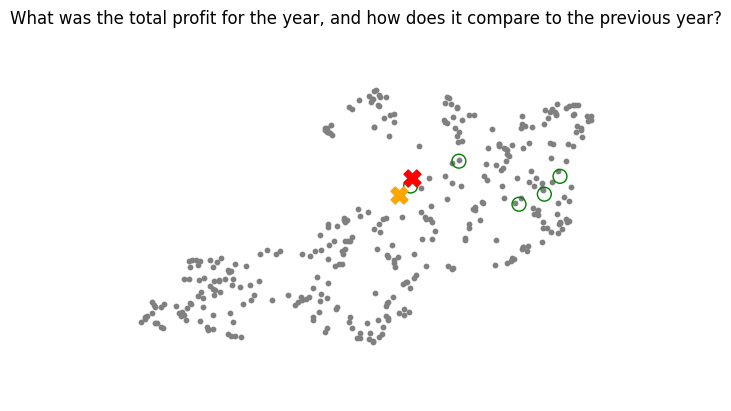

In [1]:
from helper_utils import project_embeddings, word_wrap
from pypdf import PdfReader
import os
from openai import OpenAI
from dotenv import load_dotenv

from pypdf import PdfReader
import umap


# Load environment variables from .env file
load_dotenv()

# openai_key = os.getenv("OPENAI_API_KEY")
# client = OpenAI(api_key=openai_key)

gemini_api_key = os.getenv('GEMINI_API_KEY')
client = OpenAI(base_url="https://generativelanguage.googleapis.com/v1beta/openai/", api_key=gemini_api_key)

reader = PdfReader("data/microsoft-annual-report.pdf")
pdf_texts = [p.extract_text().strip() for p in reader.pages]

# Filter the empty strings
pdf_texts = [text for text in pdf_texts if text]
# print(
#     word_wrap(
#         pdf_texts[0],
#         width=100,
#     )
# )

# split the text into smaller chunks


from langchain.text_splitter import (
    RecursiveCharacterTextSplitter,
    SentenceTransformersTokenTextSplitter,
)

# There are two splitters
# RecursiveCharacterTextSplitter - "dum splitter" that splits first by \n\n and if the length is still too large then uses \n until
#    it reaches the defined chunk_size = 1000
# SentenceTransformersTokenTextSplitter - split the text into chunks that fit the token window of the sentence transformer model that you would like to use.
character_splitter = RecursiveCharacterTextSplitter(
    separators=["\n\n", "\n", ". ", " ", ""], chunk_size=1000, chunk_overlap=0
)
character_split_texts = character_splitter.split_text("\n\n".join(pdf_texts))

# print(word_wrap(character_split_texts[10]))
# print(f"\nTotal chunks: {len(character_split_texts)}")

token_splitter = SentenceTransformersTokenTextSplitter(
    chunk_overlap=0, tokens_per_chunk=256
)
token_split_texts = []
for text in character_split_texts:
    token_split_texts += token_splitter.split_text(text)

# print(word_wrap(token_split_texts[10]))
# print(f"\nTotal chunks: {len(token_split_texts)}")


import chromadb
from chromadb.utils.embedding_functions import SentenceTransformerEmbeddingFunction

embedding_function = SentenceTransformerEmbeddingFunction()
# print(embedding_function([token_split_texts[10]]))

chroma_client = chromadb.Client()
chroma_collection = chroma_client.create_collection(
    "microsoft-collection", embedding_function=embedding_function
)

# extract the embeddings of the token_split_texts
ids = [str(i) for i in range(len(token_split_texts))]
chroma_collection.add(ids=ids, documents=token_split_texts)
chroma_collection.count()

query = "What was the total revenue for the year?"


results = chroma_collection.query(query_texts=[query], n_results=5)
retrieved_documents = results["documents"][0]

# for document in retrieved_documents:
#     print(word_wrap(document))
#     print("\n")


def augment_query_generated(query, model="gemini-2.5-flash"):
    prompt = """You are a helpful expert financial research assistant. 
   Provide an example answer to the given question, that might be found in a document like an annual report."""
    messages = [
        {
            "role": "system",
            "content": prompt,
        },
        {"role": "user", "content": query},
    ]

    response = client.chat.completions.create(
        model=model,
        messages=messages,
    )
    content = response.choices[0].message.content
    return content


original_query = "What was the total profit for the year, and how does it compare to the previous year?"
# hypothetical_answer is a hallucinated answer that will serve as an example for when we have the documents
# that will serve as basis for generating a real answer
hypothetical_answer = augment_query_generated(original_query)

joint_query = f"{original_query} {hypothetical_answer}"
print(word_wrap(joint_query))

results = chroma_collection.query(
    query_texts=joint_query, n_results=5, include=["documents", "embeddings"]
)
retrieved_documents = results["documents"][0]


# for doc in retrieved_documents:
#     print(word_wrap(doc))
#     print("")

embeddings = chroma_collection.get(include=["embeddings"])["embeddings"]
umap_transform = umap.UMAP(random_state=0, transform_seed=0).fit(embeddings)
projected_dataset_embeddings = project_embeddings(embeddings, umap_transform)


retrieved_embeddings = results["embeddings"][0]
original_query_embedding = embedding_function([original_query])
augmented_query_embedding = embedding_function([joint_query])

projected_original_query_embedding = project_embeddings(
    original_query_embedding, umap_transform
)
projected_augmented_query_embedding = project_embeddings(
    augmented_query_embedding, umap_transform
)
projected_retrieved_embeddings = project_embeddings(
    retrieved_embeddings, umap_transform
)

import matplotlib.pyplot as plt

# Plot the projected query and retrieved documents in the embedding space
plt.figure()

plt.scatter(
    projected_dataset_embeddings[:, 0],
    projected_dataset_embeddings[:, 1],
    s=10,
    color="gray",
)
plt.scatter(
    projected_retrieved_embeddings[:, 0],
    projected_retrieved_embeddings[:, 1],
    s=100,
    facecolors="none",
    edgecolors="g",
)
plt.scatter(
    projected_original_query_embedding[:, 0],
    projected_original_query_embedding[:, 1],
    s=150,
    marker="X",
    color="r",
)
plt.scatter(
    projected_augmented_query_embedding[:, 0],
    projected_augmented_query_embedding[:, 1],
    s=150,
    marker="X",
    color="orange",
)

plt.gca().set_aspect("equal", "datalim")
plt.title(f"{original_query}")
plt.axis("off")
plt.show()  # display the plot
